In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

**Exercise 3: Implicit solution to the diffusion equation**

Solve the same problem as in exercise 2 but using an implicit method. Check the accuracy and stability of the solution by comparing it to the analytical solution for various values of the time step.

This is a function that I downloaded from the internet and which solves a tridiagonal system of equations (see header for explanation/use)

In [2]:
@numba.njit
## Tri Diagonal Matrix Algorithm(a.k.a Thomas algorithm) solver
def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    a is lower diagonal
    b is diagonal
    c is upper diagonal
    d is rhs
    '''
    nf = len(d) # number of equations
    ac = a.copy()
    bc = b.copy()
    cc = c.copy()
    dc = d.copy()
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

2. Let's find the solution to our diffusion equation using an implicit scheme

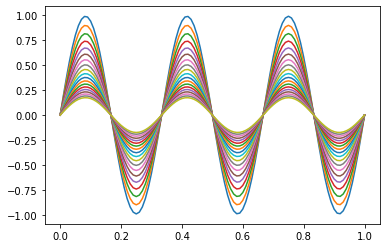

In [3]:
nx = 101
xl = 1
x = np.linspace(0,xl,nx)

nperiod = 3
h = np.sin(2*np.pi*x/xl*nperiod)

dx = xl/(nx-1)
tf = 0.005
nstep = 201
nfreq = 11
dt = tf/nstep
kd = 1
tau = (xl/nperiod)**2/kd/(2*np.pi)**2

fact = kd*dt/dx**2
diag = np.ones(nx)+2*fact
sup = -np.ones(nx-1)*fact
inf = -np.ones(nx-1)*fact
diag[0] = 1
diag[-1] = 1
sup[0] = 0
inf[-1] = 0

for istep in range(nstep):
    h = TDMAsolver(inf, diag, sup, h)
    if istep%nfreq==0: plt.plot(x,h)

3. Let's build a function (similar to the one we used in the previous equation) to find the error and the stability condition but using the implicit scheme

In [4]:
@numba.njit
def find_error(nx,nstep,nperiod):
    xl = 1
    x = np.linspace(0,xl,nx)
    h = np.sin(2*np.pi*x/xl*nperiod)
    dx = xl/(nx-1)
    tf = 0.005
    dt = tf/nstep
    kd = 1
    fact = kd*dt/dx**2
    tau = (xl/nperiod)**2/kd/(2*np.pi)**2
    hist = np.zeros(nstep)
    hana = np.zeros_like(hist)
    diag = np.ones(nx)+2*fact
    sup = -np.ones(nx-1)*fact
    inf = -np.ones(nx-1)*fact
    diag[0] = 1
    diag[-1] = 1
    sup[0] = 0
    inf[-1] = 0
    for istep in range(nstep):
        h = TDMAsolver(inf, diag, sup, h)
        hist[istep] = h.max()
        hana[istep] = np.exp(-((istep+1)*dt/tau))
        if hist[istep]>hana[istep]*2: return np.nan, fact
    return np.abs(hana-hist).max(), fact

4. Let's check it

In [5]:
nx = 101
nstep = 201
nfreq = 2
print(nx, nstep, nfreq, find_error(nx, nstep, nfreq))

101 201 2 (0.0019527692567435917, 0.24875621890547261)


5. Let's see how the error evolves for a range of values of $n_x$ and $n_{step}$ 

In [6]:
nx_range = [21, 101, 201, 1001, 2001, 10001]
nstep_range = [10, 100, 1000, 10000, 100000, 1000000]
error = np.zeros((len(nx_range),len(nstep_range),2))
for i in range(len(nx_range)):
    for j in range(len(nstep_range)):
        error[i, j, :] = find_error(nx_range[i], nstep_range[j], 4)

IOStream.flush timed out


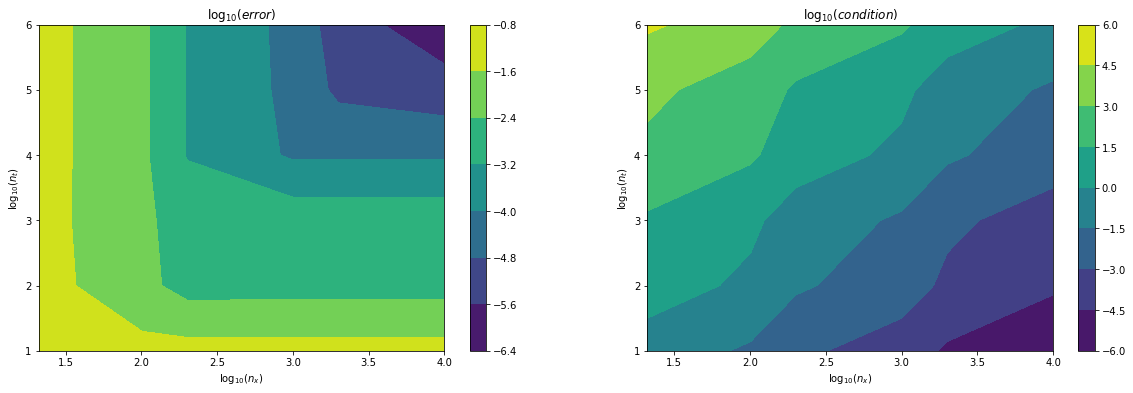

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20,6))

contour0 = ax[0].contourf(np.log10(nx_range), np.log10(nstep_range), np.log10(error[:,:,0]))
fig.colorbar(contour0, ax=ax[0])

contour1 = ax[1].contourf(np.log10(nx_range), np.log10(nstep_range), np.log10(error[:,:,1]))
fig.colorbar(contour1, ax=ax[1])

ax[0].set_xlabel('$\log_{10}(n_x)$')
ax[0].set_ylabel('$\log_{10}(n_t)$')
ax[0].set_title('$\log_{10}(error)$');

ax[1].set_xlabel('$\log_{10}(n_x)$')
ax[1].set_ylabel('$\log_{10}(n_t)$')
ax[1].set_title('$\log_{10}(condition)$');
